<a href="https://colab.research.google.com/github/rafaelrubo/python-geociencias/blob/main/python_geociencias07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python Aplicado às Geociências
##Parte 07
#####Rafael Rubo
#####rafaelrubo@gmail.com

In [1]:
import matplotlib.pyplot as plt

# Carregando imagem RGB​
img = plt.imread("satelite.png")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel, gaussian_filter, laplace

# Separar os canais da imagem
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]

# Filtro Sobel (realce de bordas)
sobel_R = sobel(R)
sobel_G = sobel(G)
sobel_B = sobel(B)

# Filtro Gaussiano (suavização, sigma=1)
gauss_R = gaussian_filter(R, sigma=1)
gauss_G = gaussian_filter(G, sigma=1)
gauss_B = gaussian_filter(B, sigma=1)

# Diferença de Gaussianas (DoG = Gauss(sigma=1) - Gauss(sigma=2))
dog_R = gaussian_filter(R, sigma=1) - gaussian_filter(R, sigma=2)
dog_G = gaussian_filter(G, sigma=1) - gaussian_filter(G, sigma=2)
dog_B = gaussian_filter(B, sigma=1) - gaussian_filter(B, sigma=2)

# Aprox. da Hessiana: traço da matriz Hessiana via Laplaciano (segunda derivada)
hess_R = laplace(R)
hess_G = laplace(G)
hess_B = laplace(B)

# Empilhar todos os atributos por pixel (15 variáveis)
X = np.stack([
    R.ravel(), G.ravel(), B.ravel(),                          # 3
    sobel_R.ravel(), sobel_G.ravel(), sobel_B.ravel(),        # 3
    gauss_R.ravel(), gauss_G.ravel(), gauss_B.ravel(),        # 3
    dog_R.ravel(), dog_G.ravel(), dog_B.ravel(),              # 3
    hess_R.ravel(), hess_G.ravel(), hess_B.ravel()            # 3
], axis=1)

In [3]:
# Máscara de pixels rotulados
mask = np.zeros((100, 100), dtype=bool)
pixels_anotados = [
    (90, 50), (80, 40), (75, 75), (10, 75),  # vegetação
    (0, 0), (4, 20), (30, 10), (40, 30),  # solo exposto
    (50, 50), (40, 60), (25, 90), (60, 35)  # água
]
for i, j in pixels_anotados:
    mask[i, j] = True

In [4]:
# Rótulos correspondentes aos pixels anotados
labels = np.array([
    0, 0, 0, 0,        # vegetação
    1, 1, 1, 1,        # solo exposto
    2, 2, 2, 2         # água
])

In [5]:
# Preparar atributos por pixel
X = X.reshape(-1, 15)                  # vetor (1000, 3)
mask_flat = mask.ravel()               # vetor (1000,)
X_train = X[mask_flat]                 # atributos apenas dos rotulados
y_train = labels                       # rótulos 1D

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Treinar modelo Random Forest
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [7]:
# Previsão para todos os pixels
y_pred = clf.predict(X)
segmented = y_pred.reshape(100, 100)

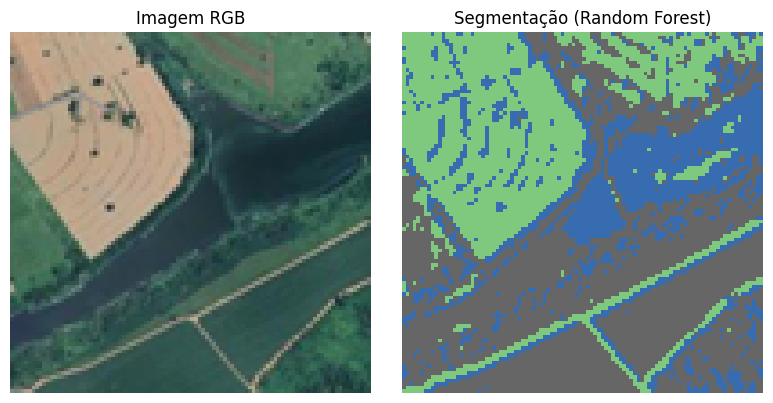

In [8]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img)
axes[0].set_title("Imagem RGB")
axes[0].axis('off')

im = axes[1].imshow(segmented, cmap='Accent', vmin=0, vmax=2)
axes[1].set_title("Segmentação (Random Forest)")
axes[1].axis('off')

#plt.colorbar(im, ax=axes[1], ticks=[0, 1, 2], label='Classe')
plt.tight_layout()
plt.show()